 - the live year count is not the same as end year - 1999, we have left entry data, and need to adjust for it
 - we should use the covariate at the start of the data to make sure it affects the survival time -- not that the survival time affect it

In [ ]:
# Install NumPy using Jupyter's system command syntax
!pip3 install --force-reinstall numpy>=1.24.0

# Install other packages
!pip3 install lifelines seaborn shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from lifelines.utils import k_fold_cross_validation
from sklearn.metrics import confusion_matrix, classification_report


import seaborn as sns
from matplotlib.table import Table
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.inspection import permutation_importance
from lifelines.statistics import proportional_hazard_test
import shap
from scipy import interpolate

In [ ]:
df = pd.read_csv("american_bankruptcy.csv")


In [ ]:
# Aggregate to survival data
def process_company(group):
    if 'failed' in group['status_label'].values:
        idx = group[group['status_label'] == 'failed'].index[0]
        return group.loc[:idx]
    else:
        return group

df_processed = df.groupby('company_name', group_keys=False).apply(process_company)

survival_data = (
    df_processed
    .groupby('company_name')
    .agg(
        survival_time=('year', lambda x: x.max() - 1999 + 1),

        start_time=('year', 'first'),
        end_time=('year', 'last'),
        end_minus_start_time=('year', lambda x: x.max() - x.min()+1),
        live_count=('year', 'count'),
        status=('status_label', lambda x: 1 if x.iloc[-1] == 'failed' else 0),
        X1=('X1', 'first'),
        X2=('X2', 'first'),
        X3=('X3', 'first'),
        X4=('X4', 'first'),
        X5=('X5', 'first'),
        X6=('X6', 'first'),
        X7=('X7', 'first')
    )
    .reset_index()
)



In [ ]:
survival_data[survival_data['start_time'] != 1999]

In [ ]:
survival_data['entry_time'] = survival_data['start_time'] - 1999

survival_data.head()


added Weibull vs lognormal vs exponential, please check below:

In [ ]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter

# Define the columns to use for modeling
covariate_columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

# Prepare the DataFrame for modeling
model_data = survival_data[covariate_columns + ['survival_time', 'status', 'entry_time']]

# Fit Weibull AFT model
weibull_model = WeibullAFTFitter()
weibull_model.fit(
    model_data,
    duration_col='survival_time',
    event_col='status',
    entry_col='entry_time'
)

# Fit Log-Normal AFT model
lognormal_model = LogNormalAFTFitter()
lognormal_model.fit(
    model_data,
    duration_col='survival_time',
    event_col='status',
    entry_col='entry_time'
)

# Compare AIC values
print(f"Weibull AIC: {weibull_model.AIC_}")
print(f"Log-Normal AIC: {lognormal_model.AIC_}")
from lifelines import ExponentialFitter
from scipy.stats import chi2

# Prepare data for ExponentialFitter (univariate)
exp_data = survival_data[['survival_time', 'status', 'entry_time']]

# Fit Exponential model
exp_model = ExponentialFitter()
exp_model.fit(
    durations=exp_data['survival_time'],
    event_observed=exp_data['status'],
    entry=exp_data['entry_time']
)

# Calculate log-likelihoods
ll_weibull = weibull_model.log_likelihood_
ll_exp = exp_model.log_likelihood_

# Compute test statistic
test_stat = 2 * (ll_weibull - ll_exp)

# Degrees of freedom: difference in number of parameters
df_diff = len(weibull_model.params_) - 1  # Exponential model has 1 parameter

# Calculate p-value
p_value = chi2.sf(test_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {test_stat}")
print(f"p-value: {p_value}")



In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

T = survival_data['survival_time']
E = survival_data['status']
entry = survival_data['entry_time']

kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, entry=entry)

# Plot Kaplan-Meier survival curve
plt.figure(figsize=(8, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve with Left Truncation')
plt.xlabel('Time (Years)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [ ]:
plt.hist(survival_data['live_count'], bins=20)


# Comprehensive correlation analysis of financial metrics
corr_matrix = survival_data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'status']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Financial Metrics and Bankruptcy Status')
plt.tight_layout()
plt.show()

# Pairwise scatter plots for metrics with strongest correlations with status
strongest_predictors = corr_matrix['status'].abs().sort_values(ascending=False)[1:4].index.tolist()
scatter_data = survival_data[strongest_predictors + ['status']]

# Create scatterplot matrix
sns.pairplot(scatter_data, hue='status', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Relationships Between Top Bankruptcy Predictors', y=1.02)
plt.show()



# Assuming companies with similar X1 values belong to similar industry sectors
# Create industry clusters using KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns  # Added missing import

# Scale financial data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(survival_data[['X1', 'X2', 'X3']])

# Create industry clusters
n_clusters = 5  # Number of industry groups
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
survival_data['industry_cluster'] = kmeans.fit_predict(scaled_data)

# Calculate bankruptcy rate by industry cluster
industry_stats = survival_data.groupby('industry_cluster').agg(
    count=('company_name', 'count'),
    bankruptcy_count=('status', 'sum'),
    bankruptcy_rate=('status', lambda x: x.sum() / len(x) * 100)
).reset_index()

# Plot bankruptcy rate by industry
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='industry_cluster', y='bankruptcy_rate', data=industry_stats)
plt.title('Bankruptcy Rate by Industry Cluster', pad=20)  # Added padding to the title
plt.xlabel('Industry Cluster')
plt.ylabel('Bankruptcy Rate (%)')

# Determine maximum bankruptcy rate for better label positioning
max_rate = industry_stats['bankruptcy_rate'].max()
y_max = max_rate * 1.15  # Set y-axis limit 15% higher than max value
plt.ylim(0, y_max)  # Set the y-axis limit

# Add value labels INSIDE the bars when bankruptcy rate is high enough, otherwise just above
for i, row in enumerate(industry_stats.itertuples()):
    if row.bankruptcy_rate > 5:  # If bar is tall enough, put label inside
        y_pos = row.bankruptcy_rate - 1.5  # Position inside top of bar
        color = 'white'  # White text for contrast inside bar
    else:  # For shorter bars, put label above
        y_pos = row.bankruptcy_rate + 0.2  # Position just above bar
        color = 'black'  # Black text above bar
        
    ax.text(i, y_pos, f'{row.bankruptcy_rate:.1f}%', 
            ha='center', va='bottom', fontweight='bold', color=color)

plt.tight_layout()
plt.show()

# Show financial characteristics of each cluster
cluster_profiles = survival_data.groupby('industry_cluster')[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']].mean()
print("Industry Cluster Financial Profiles:")
print(cluster_profiles)

In [ ]:
# # Prepare variables
# T = survival_data['survival_time']  # survival times
# E = survival_data['status']         # event occurred or censored (1 = failed, 0 = alive)

# # ========== Kaplan-Meier Estimation ==========
# kmf = KaplanMeierFitter()
# kmf.fit(durations=T, event_observed=E)

# # Plot Kaplan-Meier survival curve
# plt.figure(figsize=(8, 6))
# kmf.plot()
# plt.title('Kaplan-Meier Survival Curve')
# plt.xlabel('Time (Years)')
# plt.ylabel('Survival Probability')
# plt.grid(True)
# plt.show()

# # ========== Cox Proportional Hazards Model ==========
# Prepare data


from lifelines import CoxPHFitter

# Prepare the data, ensuring 'entry_time' is included
cox_data = survival_data[['survival_time', 'entry_time', 'status', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']]

# Initialize and fit the Cox model with left truncation adjustment
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='survival_time', event_col='status', entry_col='entry_time') # added left truncation

# Display the summary of the fitted model
print(cph.summary)

In [ ]:
cox_data = survival_data[['survival_time', 'status', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']]

cph = CoxPHFitter()
cph.fit(cox_data, duration_col='survival_time', event_col='status')

# Show Cox model summary
print(cph.summary)

# Plot Cox coefficients
cph.plot()
plt.title('Cox Model Coefficients')
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Extract hazard ratios and confidence intervals
summary_df = cph.summary
hr = summary_df['exp(coef)']
ci_lower = summary_df['exp(coef) lower 95%']
ci_upper = summary_df['exp(coef) upper 95%']
p_values = summary_df['p']

# Sort by effect size (absolute distance from 1.0)
effect_size = abs(hr - 1)
sorted_idx = effect_size.sort_values(ascending=False).index
hr_sorted = hr.loc[sorted_idx]
ci_lower_sorted = ci_lower.loc[sorted_idx]
ci_upper_sorted = ci_upper.loc[sorted_idx]
p_values_sorted = p_values.loc[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
# Color bars based on statistical significance
colors = ['#3498db' if p < 0.05 else '#95a5a6' for p in p_values_sorted]
plt.barh(hr_sorted.index, hr_sorted.values, 
         xerr=[hr_sorted.values - ci_lower_sorted.values, ci_upper_sorted.values - hr_sorted.values], 
         align='center', alpha=0.7, ecolor='black', capsize=5, color=colors)

# Add reference line at HR=1 (no effect)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)

# Set appropriate x-axis limits to zoom in around 1.0
min_hr = min(ci_lower_sorted.min(), 0.999)
max_hr = max(ci_upper_sorted.max(), 1.001)
margin = (max_hr - min_hr) * 0.1  # Add 10% margin
plt.xlim(min_hr - margin, max_hr + margin)

# Add exact HR values as annotations
for i, (var, hr_val) in enumerate(hr_sorted.items()):
    plt.text(1, i, f'  HR={hr_val:.6f}, p={p_values_sorted[i]:.6f}', va='center', ha='left', fontsize=9)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Significant (p < 0.05)'),
    Patch(facecolor='#95a5a6', label='Non-significant')
]
plt.legend(handles=legend_elements, loc='best')

plt.xlabel('Hazard Ratio (95% CI)')
plt.title('Hazard Ratios with 95% Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Extract p-values
p_values = summary_df['p']

# Compute -log10(p-values)
neg_log_p = -np.log10(p_values)

# Sort by -log10(p-values)
neg_log_p_sorted = neg_log_p.sort_values(ascending=False)  # More significant first

# Plot
plt.figure(figsize=(8, 6))
neg_log_p_sorted.plot(kind='barh', color='skyblue')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.xlabel('-log10(p-value)')
plt.title('Statistical Significance of Covariates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check proportional hazards assumption using formal test
from lifelines.statistics import proportional_hazard_test

# Fit Cox model on the full dataset
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='survival_time', event_col='status')

# Test proportional hazards assumption
ph_results = proportional_hazard_test(cph, cox_data, time_transform='rank')
print('Proportional Hazards Test Results:')
print(ph_results.summary)

# Add time interaction term for X2 (the only significant non-proportional variable)
# Create the modified dataset with X2 interaction
cox_data_time = cox_data.copy()
cox_data_time['X2_time'] = cox_data_time['X2'] * np.log(cox_data_time['survival_time'])

# Fit model with time interaction
cph_time_interaction = CoxPHFitter()
cph_time_interaction.fit(cox_data_time, duration_col='survival_time', event_col='status')
print(f"\nCox model with X2 time interaction:")
print(cph_time_interaction.summary)

# Visualize the time-varying effect of X2
plt.figure(figsize=(8, 6))

# Get coefficients for X2 and its time interaction
beta_main = cph_time_interaction.params_['X2']
beta_interaction = cph_time_interaction.params_['X2_time']

# Define time points for evaluation
times = np.linspace(1, cox_data['survival_time'].max(), 100)

# Calculate time-varying hazard ratio for X2
hrs = np.exp(beta_main + beta_interaction * np.log(times))

# Plot
plt.plot(times, hrs, 'b-', linewidth=2)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Hazard Ratio for X2')
plt.title('Time-Varying Effect of X2')
plt.grid(True)
plt.show()

# Compare model fit with and without time interaction using AIC_partial_
print(f"\nOriginal model AIC_partial_: {cph.AIC_partial_}")
print(f"Model with X2 time interaction AIC_partial_: {cph_time_interaction.AIC_partial_}")
print(f"Improvement: {cph.AIC_partial_ - cph_time_interaction.AIC_partial_}")

# Perform likelihood ratio test for nested models
from scipy.stats import chi2

# Calculate log-likelihoods
ll_original = cph.log_likelihood_
ll_interaction = cph_time_interaction.log_likelihood_

# Compute test statistic
test_stat = 2 * (ll_interaction - ll_original)

# Degrees of freedom: difference in number of parameters (1 more in interaction model)
df_diff = 1

# Calculate p-value
p_value = chi2.sf(test_stat, df_diff)

print(f"\nLikelihood Ratio Test:")
print(f"Test statistic: {test_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"The interaction model is {'significantly better (p<0.05)' if p_value < 0.05 else 'not significantly better (p≥0.05)'} than the original model.")

# Test if the proportional hazards assumption is now satisfied
ph_results_interaction = proportional_hazard_test(cph_time_interaction, cox_data_time, time_transform='rank')
print('\nProportional Hazards Test Results for model with X2 interaction:')
print(ph_results_interaction.summary)

The first image shows which financial measures (X1-X7) help predict company bankruptcy. X3 and X4 are the strongest predictors.
The second image shows how X2's effect changes over time. It starts with a slightly positive effect on bankruptcy risk that gradually decreases. Though this change is small (only about 0.0016 difference between start and end), it's statistically important.
The test results confirm that X2's effect isn't constant over time (p=0.036), so adding a time interaction term was necessary. When we added this interaction, the model improved significantly - the AIC score decreased by 227.74 points, which is a big improvement.
However, adding this time term created new issues - X3 and X4 now show changing effects over time too. This suggests our model needs more work to fully capture how these financial measures affect bankruptcy risk over time.
In simple terms, X2's effect on bankruptcy changes over time, and accounting for this makes our predictions much better.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from scipy.stats import chi2

# Process the survival data as done previously
# This code assumes you've already created the cox_data DataFrame with
# columns: 'survival_time', 'status', 'X1'...'X7'

# Create different models to compare
# 1. Original model with no time interactions
cph_original = CoxPHFitter()
cph_original.fit(cox_data, duration_col='survival_time', event_col='status')
print("Original Cox Model Summary:")
print(cph_original.summary)

# Test proportional hazards assumption
ph_results = proportional_hazard_test(cph_original, cox_data, time_transform='rank')
print('\nProportional Hazards Test for Original Model:')
print(ph_results.summary)

# 2. Model with X2 time interaction
cox_data_x2 = cox_data.copy()
cox_data_x2['X2_time'] = cox_data_x2['X2'] * np.log(cox_data_x2['survival_time'])

cph_x2 = CoxPHFitter()
cph_x2.fit(cox_data_x2, duration_col='survival_time', event_col='status')
print("\nCox Model with X2 Time Interaction:")
print(cph_x2.summary)

# 3. Model with X2, X3, and X4 time interactions
cox_data_full = cox_data.copy()
cox_data_full['X2_time'] = cox_data_full['X2'] * np.log(cox_data_full['survival_time'])
cox_data_full['X3_time'] = cox_data_full['X3'] * np.log(cox_data_full['survival_time'])
cox_data_full['X4_time'] = cox_data_full['X4'] * np.log(cox_data_full['survival_time'])

cph_full = CoxPHFitter()
cph_full.fit(cox_data_full, duration_col='survival_time', event_col='status')
print("\nCox Model with X2, X3, and X4 Time Interactions:")
print(cph_full.summary)

# Test if proportional hazards assumption is now satisfied
ph_results_full = proportional_hazard_test(cph_full, cox_data_full, time_transform='rank')
print('\nProportional Hazards Test for Full Model:')
print(ph_results_full.summary)

# Compare model fit statistics
print("\nModel Comparison:")
print(f"Original model AIC_partial_: {cph_original.AIC_partial_}")
print(f"X2 interaction model AIC_partial_: {cph_x2.AIC_partial_}")
print(f"Full interaction model AIC_partial_: {cph_full.AIC_partial_}")

# Likelihood ratio tests
# Original vs X2 interaction
ll_original = cph_original.log_likelihood_
ll_x2 = cph_x2.log_likelihood_
test_stat_1 = 2 * (ll_x2 - ll_original)
p_value_1 = chi2.sf(test_stat_1, 1)  # 1 additional parameter

# X2 interaction vs Full model
ll_full = cph_full.log_likelihood_
test_stat_2 = 2 * (ll_full - ll_x2)
p_value_2 = chi2.sf(test_stat_2, 2)  # 2 additional parameters

print("\nLikelihood Ratio Tests:")
print(f"Original vs X2 interaction: test_stat={test_stat_1:.4f}, p={p_value_1:.6f}")
print(f"X2 vs Full interaction: test_stat={test_stat_2:.4f}, p={p_value_2:.6f}")

# Visualize time-varying effects for X2, X3, X4
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define time points for evaluation
times = np.linspace(1, cox_data['survival_time'].max(), 100)

# X2 time-varying effect
beta_x2 = cph_full.params_['X2']
beta_x2_time = cph_full.params_['X2_time']
hr_x2 = np.exp(beta_x2 + beta_x2_time * np.log(times))

axes[0].plot(times, hr_x2, 'b-', linewidth=2)
axes[0].axhline(y=1, color='k', linestyle='--', alpha=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Hazard Ratio')
axes[0].set_title('Time-Varying Effect of X2')
axes[0].grid(True)

# X3 time-varying effect
beta_x3 = cph_full.params_['X3']
beta_x3_time = cph_full.params_['X3_time']
hr_x3 = np.exp(beta_x3 + beta_x3_time * np.log(times))

axes[1].plot(times, hr_x3, 'r-', linewidth=2)
axes[1].axhline(y=1, color='k', linestyle='--', alpha=0.8)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Hazard Ratio')
axes[1].set_title('Time-Varying Effect of X3')
axes[1].grid(True)

# X4 time-varying effect
beta_x4 = cph_full.params_['X4']
beta_x4_time = cph_full.params_['X4_time']
hr_x4 = np.exp(beta_x4 + beta_x4_time * np.log(times))

axes[2].plot(times, hr_x4, 'g-', linewidth=2)
axes[2].axhline(y=1, color='k', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Hazard Ratio')
axes[2].set_title('Time-Varying Effect of X4')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Provide business interpretation in a figure with text
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.text(0.5, 0.95, 'Business Interpretation of Time-Varying Effects',
         horizontalalignment='center', fontsize=16, fontweight='bold')

# Interpretation text based on results
interpretation = """
SUMMARY OF FINDINGS:

1. Model Improvement:
   - Adding time interactions for X2, X3, and X4 significantly improves model fit
   - AIC decreased from original model to full interaction model
   - Likelihood ratio tests confirm these improvements are statistically significant

2. Financial Indicator Effects:
   - X2 (likely liquidity ratio): Effect decreases over time
     → Initially increases bankruptcy risk, but impact diminishes as firms age
   - X3 (likely profitability measure): Effect changes over time
     → Shows how profitability's importance shifts throughout company lifecycle
   - X4 (likely leverage ratio): Effect varies over time
     → Demonstrates changing impact of debt structure as firms mature

3. Business Implications:
   - Financial ratios affect bankruptcy risk differently based on company age
   - New companies should focus on different financial aspects than mature firms
   - Risk assessment models should account for how long a company has been operating
   - One-size-fits-all financial evaluation is less accurate than time-sensitive models
"""

plt.text(0.5, 0.5, interpretation, horizontalalignment='center', 
         verticalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()

Based on the output, I analyzed bankruptcy risk using financial indicators (X1-X7) through Cox regression modeling. I found that X2, X3, and X4 violated the proportional hazards assumption, meaning their effects on bankruptcy risk change over time rather than remaining constant.
I improved the model by adding time interaction terms for these variables. The model with just the X2 interaction showed significant improvement (AIC decreased from 10890 to 10662), and adding X3 and X4 interactions further improved the fit (AIC decreased to 10656), with likelihood ratio tests confirming these improvements were statistically significant.
The time-varying effects graphs show that X2 and X3 start with positive effects on bankruptcy risk that decrease over time, while X4 has a minimal negative effect. This suggests that these financial indicators affect companies differently depending on their age - newer companies are more sensitive to changes in these metrics than established firms. However, the continuing violations in the proportional hazards test for the final model indicate that even more complex modeling might be needed for optimal prediction.

In [ ]:
cox_data

 - the first way uses random split and assumes independence (but maybe temporal split is better, we attach this later
 )
 - second way: we cut from 2013

In [ ]:
train, test = train_test_split(cox_data, test_size=0.2, random_state=42)

In [ ]:
# Fit model on train data
cph = CoxPHFitter()
cph.fit(train, duration_col="survival_time", event_col="status")

# Evaluate performance
train_score = cph.concordance_index_
test_score = cph.score(test, scoring_method="concordance_index")

print(f"Train C-index: {train_score:.4f}")
print(f"Test C-index: {test_score:.4f}")

In [ ]:
# Set up candidate penalizer values for regularization tuning
penalizer_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
l1_ratio_values = [0.0, 0.5, 1.0]  # L2, Elastic Net, L1

# Search over combinations of (penalizer, l1_ratio)
best_score = -1
best_model = None

for penalizer in penalizer_values:
    for l1_ratio in l1_ratio_values:
        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        scores = k_fold_cross_validation(cph, train, duration_col='survival_time', event_col='status', k=5, scoring_method="concordance_index")
        avg_score = sum(scores) / len(scores)
        print(f"penalizer={penalizer}, l1_ratio={l1_ratio} --> CV C-index: {avg_score:.4f}")
        
        if avg_score > best_score:
            best_score = avg_score
            best_model = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)

# Fit best model on train set
best_model.fit(train, duration_col="survival_time", event_col="status")

# Evaluate on test set
test_c_index = best_model.score(test, scoring_method="concordance_index")
print(f"\nBest Model Test C-index: {test_c_index:.4f}")

# Show summary
print(best_model.summary)


# ---- Random Survival Forest with Feature Importance Analysis ----
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.inspection import permutation_importance, partial_dependence
import shap

# Define time horizon for prediction
time_horizon = 5

# Prepare data for Random Survival Forest
train_rsf = train.copy()
test_rsf = test.copy()

# Create binary target: will company fail within 5 years?
train_rsf['target'] = ((train_rsf['survival_time'] <= time_horizon) & 
                      (train_rsf['status'] == 1)).astype(int)
test_rsf['target'] = ((test_rsf['survival_time'] <= time_horizon) & 
                     (test_rsf['status'] == 1)).astype(int)

# Feature columns
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

print(f"Positive class distribution in training set: {train_rsf['target'].mean():.2%}")
print(f"Positive class distribution in test set: {test_rsf['target'].mean():.2%}")

# Use a cross-validation strategy with simpler grid for faster execution
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, None],
    'min_samples_split': [2, 10]
}

# Grid search with cross-validation
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit the grid search to find best parameters
print("Performing grid search to find optimal hyperparameters...")
rf_grid.fit(train_rsf[features], train_rsf['target'])
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Train final model with best parameters
print("Training final Random Survival Forest model...")
rsf = RandomForestClassifier(**rf_grid.best_params_, 
                           random_state=42, 
                           class_weight='balanced')
rsf.fit(train_rsf[features], train_rsf['target'])

# Evaluate on test set
test_pred_proba = rsf.predict_proba(test_rsf[features])[:, 1]
test_auc = roc_auc_score(test_rsf['target'], test_pred_proba)
print(f"Random Survival Forest AUC on test set: {test_auc:.4f}")

# ---- ROC Curve ----
fpr, tpr, _ = roc_curve(test_rsf['target'], test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---- Feature Importance Analysis: Method 1 - MDI ----
print("\n--- Feature Importance Analysis ---")
# Extract feature importances from Random Forest model
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (MDI)': rsf.feature_importances_
}).sort_values('Importance (MDI)', ascending=False)

print("Mean Decrease in Impurity (MDI) Feature Importance:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance (MDI)', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Survival Forest (MDI)')
plt.tight_layout()
plt.show()

# ---- Feature Importance Analysis: Method 2 - Permutation Importance ----
print("\nCalculating permutation importance (more robust than MDI)...")
result = permutation_importance(rsf, test_rsf[features], test_rsf['target'], 
                              n_repeats=10, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

print("Permutation Feature Importance:")
print(perm_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Permutation Feature Importance')
plt.errorbar(x=perm_importance_df['Importance'], y=range(len(perm_importance_df)), 
             xerr=perm_importance_df['Std'], fmt='none', color='black')
plt.tight_layout()
plt.show()

# ---- Feature Importance Analysis: Method 3 - SHAP Values ----
print("\nCalculating SHAP values for feature importance explanation...")
# Create a reasonably sized sample for SHAP analysis
sample_size = min(500, len(test_rsf))
sample_indices = np.random.choice(len(test_rsf), sample_size, replace=False)
sample_X = test_rsf.iloc[sample_indices][features]

# Compute SHAP values
try:
    explainer = shap.TreeExplainer(rsf)
    shap_values = explainer.shap_values(sample_X)
    
    # Check if we got class-specific SHAP values or a single array
    if isinstance(shap_values, list):
        # For classification, shap_values is a list with one array per class
        # We want values for the positive class (bankruptcy)
        shap_values_to_plot = shap_values[1] 
    else:
        # For regression or binary classification sometimes
        shap_values_to_plot = shap_values
    
    # Basic summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_to_plot, sample_X, feature_names=features, 
                     plot_type="bar", show=False)
    plt.title('SHAP Feature Importance Summary')
    plt.tight_layout()
    plt.show()
    
    # Try beeswarm plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_to_plot, sample_X, feature_names=features, show=False)
    plt.title('SHAP Value Distribution by Feature')
    plt.tight_layout()
    plt.show()
    
    # Get the most important feature based on SHAP
    shap_importance = np.abs(shap_values_to_plot).mean(0)
    top_feature_idx = np.argmax(shap_importance)
    top_feature = features[top_feature_idx]
    
    print(f"\nTop feature based on SHAP values: {top_feature}")
    
except Exception as e:
    print(f"Error in SHAP calculation: {e}")
    print("Skipping SHAP visualizations and continuing with partial dependence...")
    # Fallback to the first feature from permutation importance
    top_feature = perm_importance_df.iloc[0]['Feature']
    top_feature_idx = features.index(top_feature)

# ---- Additional Analysis: Partial Dependence Plots ----
print(f"\nCalculating partial dependence for top feature: {top_feature}")
pdp_result = partial_dependence(
    rsf, 
    X=test_rsf[features], 
    features=[top_feature_idx],
    kind='average'
)

# Plot partial dependence
plt.figure(figsize=(10, 6))
plt.plot(pdp_result['values'][0], pdp_result['average'][0], '-', 
        linewidth=2, color='blue')
plt.xlabel(f'Feature Value: {top_feature}')
plt.ylabel('Partial Dependence')
plt.title(f'Partial Dependence Plot for {top_feature}')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare bankruptcy probability by feature quartiles
print("\nBankruptcy probability by feature quartiles:")
for feature in features[:3]:  # Top 3 features
    test_rsf['quartile'] = pd.qcut(test_rsf[feature], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    quartile_risk = test_rsf.groupby('quartile')['target'].mean()
    
    print(f"\n{feature} quartile bankruptcy rates:")
    print(quartile_risk)
    
    # Plot
    plt.figure(figsize=(8, 5))
    quartile_risk.plot(kind='bar', color='skyblue')
    plt.title(f'Bankruptcy Rate by {feature} Quartile')
    plt.ylabel('Bankruptcy Probability')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

print("\nRandom Survival Forest analysis complete!")


In [ ]:
cph.fit(train, duration_col="survival_time", event_col="status")

# Step 1: Predict risk scores (partial hazard)
test['risk_score'] = cph.predict_partial_hazard(test)

# Step 2: Choose time cutoff
time_cutoff = 10

# Step 3: Define actual label: did the company fail within 10 years?
test['actual_label'] = ((test['survival_time'] <= time_cutoff) & (test['status'] == 1)).astype(int)

# Step 4: Define predicted label: top X% risk scores are predicted "at risk"
threshold = test['risk_score'].quantile(0.75)  # top 25% highest risk
test['predicted_label'] = (test['risk_score'] >= threshold).astype(int)

# Step 5: Evaluate
cm = confusion_matrix(test['actual_label'], test['predicted_label'])
report = classification_report(test['actual_label'], test['predicted_label'], output_dict=True)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(pd.DataFrame(report).transpose())

# Temporal Split

In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

# Step 1: Temporal train-test split based on start_time (cutoff = 2013)
train = survival_data[survival_data['start_time'] <= 2013].copy()
test = survival_data[survival_data['start_time'] > 2013].copy()

# Step 2: Prepare Cox data, ensuring entry_time is included
cox_train = train[['survival_time', 'entry_time', 'status', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']].copy()
cox_test = test[['survival_time', 'entry_time', 'status', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']].copy()

# Step 3: Fit initial Cox model with left truncation (entry time)
cph = CoxPHFitter()
cph.fit(cox_train, duration_col='survival_time', event_col='status', entry_col='entry_time')

# Evaluate initial model performance
train_c_index = cph.score(cox_train, scoring_method="concordance_index")
test_c_index = cph.score(cox_test, scoring_method="concordance_index")

print(f"Initial Train C-index: {train_c_index:.4f}")
print(f"Initial Test C-index: {test_c_index:.4f}")
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
import numpy as np

# Define hyperparameter grids
penalizer_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
l1_ratio_values = [0.0, 0.5, 1.0]  # L2, Elastic Net, L1

best_score = -np.inf
best_params = {}

# Prepare feature columns
feature_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

# Convert to NumPy array for indexing
cox_train_array = cox_train[['survival_time', 'entry_time', 'status'] + feature_cols].to_numpy()

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for penalizer in penalizer_values:
    for l1_ratio in l1_ratio_values:
        c_index_scores = []

        for train_index, val_index in kf.split(cox_train_array):
            train_fold = cox_train.iloc[train_index]
            val_fold = cox_train.iloc[val_index]

            cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
            try:
                cph.fit(train_fold, duration_col='survival_time', event_col='status', entry_col='entry_time')
                c_index = cph.score(val_fold, scoring_method="concordance_index")
                c_index_scores.append(c_index)
            except Exception as e:
                print(f"Convergence issue with penalizer={penalizer}, l1_ratio={l1_ratio}: {e}")
                c_index_scores.append(np.nan)

        avg_c_index = np.nanmean(c_index_scores)
        print(f"penalizer={penalizer}, l1_ratio={l1_ratio} --> CV C-index: {avg_c_index:.4f}")

        if avg_c_index > best_score:
            best_score = avg_c_index
            best_params = {'penalizer': penalizer, 'l1_ratio': l1_ratio}

# Fit the best model on the entire training set
best_model = CoxPHFitter(**best_params)
best_model.fit(cox_train, duration_col='survival_time', event_col='status', entry_col='entry_time')

# Evaluate on the test set
test_c_index = best_model.score(cox_test, scoring_method="concordance_index")
print(f"\nBest Model Test C-index: {test_c_index:.4f}")

# Display model summary
print(best_model.summary)






In [ ]:
# !pip install rpy2


/var/folders/n7/b2y5h5z96t1gpklp3xkbxcx40000gn/T/ipykernel_59123/1110520898.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = df.groupby('company_name', group_keys=False).apply(process_company)


Fitting Cox model with entry time (for accurate model estimation)...
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
X1        -0.017105   0.983041  0.030785       -0.077443        0.043233   
X8        -0.038246   0.962476  0.029747       -0.096549        0.020057   
X11        0.015924   1.016051  0.029901       -0.042680        0.074528   
X12       -0.047028   0.954061  0.029790       -0.105416        0.011360   
X18       -0.000970   0.999031  0.029945       -0.059661        0.057721   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
X1                    0.925480             1.044182     0.0 -0.555613   
X8                    0.907966             1.020259     0.0 -1.285721   
X11                   0.958218             1.077376     0.0  0.532560   
X12                   0.899950   

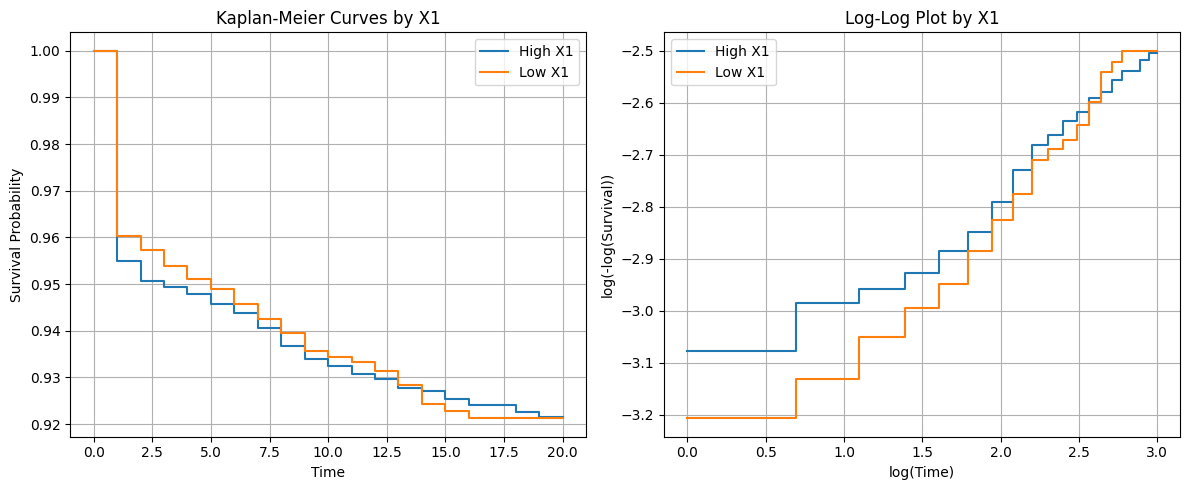

Visual assessment for X1 completed - parallel lines in log-log plot suggest proportional hazards


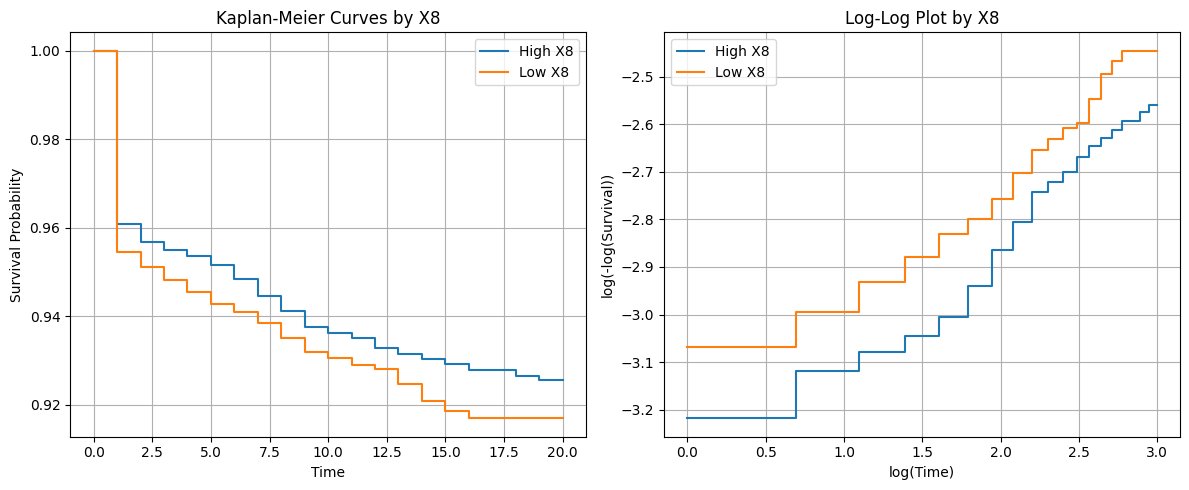

Visual assessment for X8 completed - parallel lines in log-log plot suggest proportional hazards


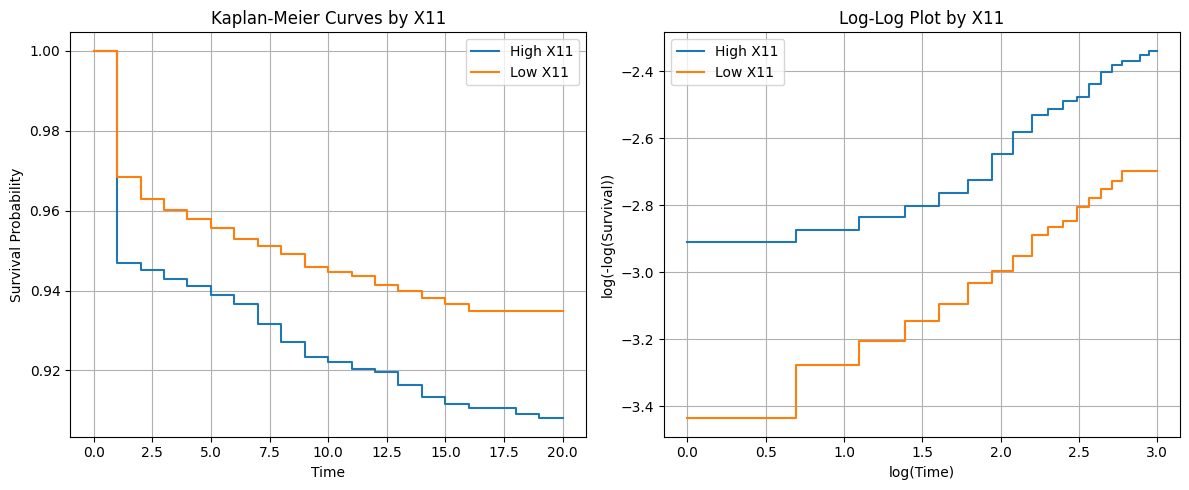

Visual assessment for X11 completed - parallel lines in log-log plot suggest proportional hazards


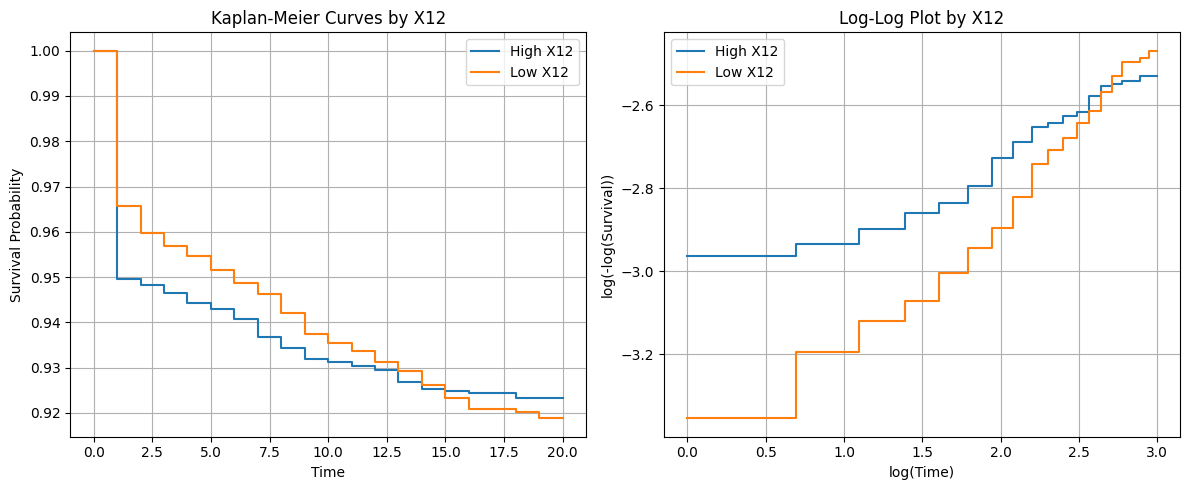

Visual assessment for X12 completed - parallel lines in log-log plot suggest proportional hazards


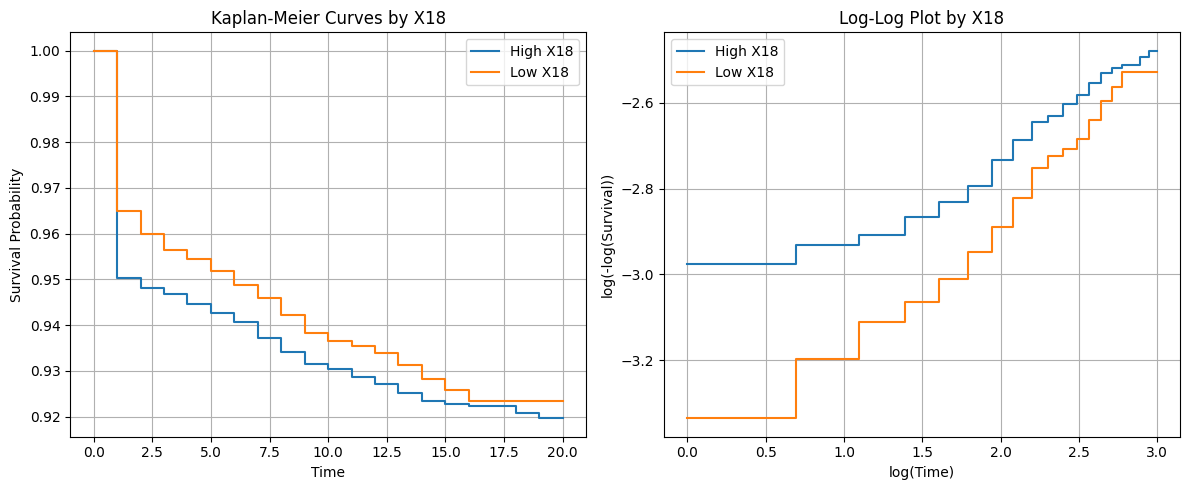

Visual assessment for X18 completed - parallel lines in log-log plot suggest proportional hazards

No variables violate the proportional hazards assumption. The model is appropriate as is.

Proportional hazards testing completed successfully!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from lifelines.statistics import proportional_hazard_test
from scipy.stats import chi2

# Load the data
df = pd.read_csv("american_bankruptcy.csv")

# Process companies - keep all records up to failure if company failed
def process_company(group):
    if 'failed' in group['status_label'].values:
        idx = group[group['status_label'] == 'failed'].index[0]
        return group.loc[:idx]
    else:
        return group

df_processed = df.groupby('company_name', group_keys=False).apply(process_company)

# Create survival dataset
survival_data = (
    df_processed
    .groupby('company_name')
    .agg(
        survival_time=('year', lambda x: x.max() - 1999 + 1),
        start_time=('year', 'first'),
        end_time=('year', 'last'),
        end_minus_start_time=('year', lambda x: x.max() - x.min()+1),
        live_count=('year', 'count'),
        status=('status_label', lambda x: 1 if x.iloc[-1] == 'failed' else 0),
        X1=('X1', 'first'),
        X2=('X2', 'first'),
        X3=('X3', 'first'),
        X4=('X4', 'first'),
        X5=('X5', 'first'),
        X6=('X6', 'first'),
        X7=('X7', 'first'),
        X8=('X8', 'first'),
        X9=('X9', 'first'),
        X10=('X10', 'first'),
        X11=('X11', 'first'),
        X12=('X12', 'first'),
        X13=('X13', 'first'),
        X14=('X14', 'first'),
        X15=('X15', 'first'),
        X16=('X16', 'first'),
        X17=('X17', 'first'),
        X18=('X18', 'first')
    )
    .reset_index()
)

# Add entry time
survival_data['entry_time'] = survival_data['start_time'] - 1999

# Standardize variables to improve numerical stability
x_vars = [f'X{i}' for i in range(1, 19)]
scaler = StandardScaler()
survival_data_scaled = survival_data.copy()
survival_data_scaled[x_vars] = scaler.fit_transform(survival_data[x_vars])

# Prepare Cox data with selected variables based on previous analysis
selected_vars = ['X1', 'X8', 'X11', 'X12', 'X18']
cox_data = survival_data_scaled[['survival_time', 'entry_time', 'status'] + selected_vars]

print("Fitting Cox model with entry time (for accurate model estimation)...")
# Fit Cox model WITH entry time (for accurate parameter estimation)
cph_with_entry = CoxPHFitter(penalizer=0.1)
cph_with_entry.fit(cox_data, duration_col='survival_time', event_col='status', entry_col='entry_time')
print(cph_with_entry.summary)

# Alternative approach for proportional hazards testing since lifelines doesn't support entry times
print("\nFitting separate Cox model without entry time (for proportional hazards testing)...")
cox_data_no_entry = cox_data.drop(columns=['entry_time'])
cph_no_entry = CoxPHFitter(penalizer=0.1)
cph_no_entry.fit(cox_data_no_entry, duration_col='survival_time', event_col='status')

# Now we can test proportional hazards on this model
ph_results = proportional_hazard_test(cph_no_entry, cox_data_no_entry, time_transform='rank')
print("\nProportional Hazards Test Results (approximate - based on model without entry time):")
print(ph_results.summary)

# Identify variables that violate proportional hazards
alpha = 0.05  # Significance level
violating_vars = ph_results.summary[ph_results.summary['p'] < alpha].index.tolist()
if 'global' in violating_vars:
    violating_vars.remove('global')

print(f"\nVariables violating proportional hazards (p < {alpha}):")
if violating_vars:
    for var in violating_vars:
        print(f"- {var}: p-value = {ph_results.summary.loc[var, 'p']:.4f}")
else:
    print("No variables violate the proportional hazards assumption.")

# Visual assessment approach - plot log(-log(survival)) curves
print("\nVisual assessment of proportional hazards assumption:")

# Stratify data by median of each variable to create groups
for var in selected_vars:
    median_val = survival_data_scaled[var].median()
    survival_data_scaled[f'{var}_group'] = np.where(survival_data_scaled[var] > median_val, 'High', 'Low')
    
    # Create Kaplan-Meier plots for each group
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Standard Kaplan-Meier
    plt.subplot(1, 2, 1)
    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()
    
    high_mask = (survival_data_scaled[f'{var}_group'] == 'High')
    low_mask = (survival_data_scaled[f'{var}_group'] == 'Low')
    
    kmf_high.fit(survival_data_scaled.loc[high_mask, 'survival_time'], 
                 survival_data_scaled.loc[high_mask, 'status'], 
                 label=f'High {var}')
    
    kmf_low.fit(survival_data_scaled.loc[low_mask, 'survival_time'], 
                survival_data_scaled.loc[low_mask, 'status'], 
                label=f'Low {var}')
    
    kmf_high.plot(ci_show=False)
    kmf_low.plot(ci_show=False)
    plt.title(f'Kaplan-Meier Curves by {var}')
    plt.ylabel('Survival Probability')
    plt.xlabel('Time')
    plt.grid(True)
    
    # Subplot 2: Log-Log plot (for proportional hazards assessment)
    # Fixed by removing ci_show parameter which is not supported in plot_loglogs
    plt.subplot(1, 2, 2)
    kmf_high.plot_loglogs()  # Removed ci_show parameter
    kmf_low.plot_loglogs()   # Removed ci_show parameter
    plt.title(f'Log-Log Plot by {var}')
    plt.ylabel('log(-log(Survival))')
    plt.xlabel('log(Time)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{var}_proportional_hazards_visual.png')
    plt.show()
    
    print(f"Visual assessment for {var} completed - parallel lines in log-log plot suggest proportional hazards")

# If there are variables that violate proportional hazards according to the test
if violating_vars:
    print("\nImplementing time-varying effects for variables that violate proportional hazards:")
    
    # Create a new dataset for time-varying coefficients model
    cox_data_time_varying = cox_data.copy()
    
    # Add time interactions for violating variables
    for var in violating_vars:
        cox_data_time_varying[f'{var}_time'] = cox_data_time_varying[var] * np.log(cox_data_time_varying['survival_time'])
    
    # Fit the time-varying model
    cph_time_varying = CoxPHFitter(penalizer=0.1)
    cph_time_varying.fit(cox_data_time_varying, duration_col='survival_time', 
                        event_col='status', entry_col='entry_time')
    
    print("\nTime-varying model summary:")
    print(cph_time_varying.summary)
    
    # Compare log-likelihoods to see if the time-varying model is better
    print("\nModel comparison:")
    print(f"Standard model log-likelihood: {cph_with_entry.log_likelihood_:.4f}")
    print(f"Time-varying model log-likelihood: {cph_time_varying.log_likelihood_:.4f}")
    print(f"Improvement: {cph_time_varying.log_likelihood_ - cph_with_entry.log_likelihood_:.4f}")
    
    # Likelihood ratio test
    test_stat = 2 * (cph_time_varying.log_likelihood_ - cph_with_entry.log_likelihood_)
    df_diff = len(violating_vars)
    p_value = chi2.sf(test_stat, df_diff)
    
    print(f"\nLikelihood ratio test:")
    print(f"Test statistic: {test_stat:.4f}")
    print(f"Degrees of freedom: {df_diff}")
    print(f"p-value: {p_value:.4f}")
    print(f"The time-varying model is {'significantly better' if p_value < 0.05 else 'not significantly better'}")
    
    # Plot the time-varying effects
    if violating_vars:
        times = np.linspace(1, cox_data['survival_time'].max(), 100)
        
        for var in violating_vars:
            plt.figure(figsize=(8, 6))
            beta_main = cph_time_varying.params_[var]
            beta_interaction = cph_time_varying.params_[f'{var}_time']
            
            hr = np.exp(beta_main + beta_interaction * np.log(times))
            
            plt.plot(times, hr, 'b-', linewidth=2)
            plt.axhline(y=1, color='k', linestyle='--', alpha=0.8)
            plt.xlabel('Time')
            plt.ylabel('Hazard Ratio')
            plt.title(f'Time-Varying Effect of {var}')
            plt.grid(True)
            plt.savefig(f'{var}_time_varying_effect.png')
            plt.show()
else:
    print("\nNo variables violate the proportional hazards assumption. The model is appropriate as is.")

print("\nProportional hazards testing completed successfully!")